In [1]:
import glob
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
from topmed_manuscript_clean import bin_integers, format_modality
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import numpy as np

PREFIX = 'Fig3C.'
GTF = '../../manuscript-intermediate-processing/data/gtf/gencode.v30.GRCh38.ERCC.genes.collapsed_only.gtf'
METADATA = '../../manuscript-intermediate-processing/data/metadata/metadata.tm.txt'

def hack_cmap(cmap_name, n):
    cmap = mpl.cm.get_cmap(cmap_name)
    cmap = cmap(range(256))
    cmap = cmap[np.linspace(0, 255, n+1).astype(int)[:-1]]
    return ListedColormap(cmap)

metadata = pd.read_csv(METADATA, sep='\t')
sample_size_dict = metadata[metadata.used_for_scan].groupby('tissue').size().to_dict()
tissue_order = list(sorted(sample_size_dict.keys(), key=lambda x: sample_size_dict[x], reverse=False))

In [2]:
to_load = glob.glob('../../manuscript-intermediate-processing/data/scan-results/joint/trans-*qtl/maf005/trans-susie/*.cs.txt')
to_load_tissues = [os.path.basename(x).split('.')[0] for x in to_load]
to_load_modalities = [format_modality(re.search('(trans-[es]qtl)', x).group(1)) for x in to_load]
susie = pd.concat([pd.read_csv(f, sep='\t').assign(tissue=os.path.basename(f).split('.')[0], modality=modality) for f, tissue, modality in zip(to_load, to_load_tissues, to_load_modalities)])
susie.head()

,phenotype_id,variant_id,pip,af,cs_id,tissue,modality
0,ENSG00000101665.9,chr1_2313782_C_T,0.121940,0.680663,1,Whole_blood,trans-eQTL
1,ENSG00000101665.9,chr1_2314848_G_C,0.845263,0.692129,1,Whole_blood,trans-eQTL
2,ENSG00000138834.12,chr1_20737330_G_GTT,0.005012,0.453905,1,Whole_blood,trans-eQTL
3,ENSG00000138834.12,chr1_20771290_G_A,0.006488,0.451503,1,Whole_blood,trans-eQTL
4,ENSG00000138834.12,chr1_20771373_A_G,0.005732,0.453595,1,Whole_blood,trans-eQTL


In [3]:
to_load = glob.glob('../../manuscript-intermediate-processing/data/scan-results/joint/trans-*qtl/maf005/trans-top/*.top.txt')
to_load_tissues = [os.path.basename(x).split('.')[0] for x in to_load]
to_load_modalities = [format_modality(re.search('(trans-[es]qtl)', x).group(1)) for x in to_load]
top = pd.concat([pd.read_csv(f, sep='\t').assign(tissue=tissue, modality=modality) for f, tissue, modality in zip(to_load, to_load_tissues, to_load_modalities)])
top = top[top.qvalue<=0.05]
top.head()

,variant_id,phenotype_id,pval,b,b_se,r2,af,gene_mappability,gene_crossmaps_to_gene_near_variant,biotype,...,pval_perm,pval_beta,pval_beta_no_zero,qvalue,tissue,modality,gene_id,phenotypes_tested_for_gene,pval_beta_corrected_across_phenotypes,pval_beta_corrected_across_phenotypes_no_zero
4,chr7_50330658_C_T,ENSG00000000938.13,3.503050e-25,-0.234596,0.022533,0.016690,0.235203,0.999762,False,protein_coding,...,0.00005,3.457262e-18,3.457262e-18,1.392881e-16,Whole_blood,trans-eQTL,NaN,NaN,NaN,NaN
16,chr1_156302480_C_T,ENSG00000002330.13,1.027770e-13,0.134956,0.018106,0.008625,0.500775,0.999556,False,protein_coding,...,0.00005,3.664337e-07,3.664337e-07,5.779733e-06,Whole_blood,trans-eQTL,NaN,NaN,NaN,NaN
35,chr6_144036619_C_A,ENSG00000004059.11,1.984040e-17,0.331091,0.038865,0.011237,0.055934,1.000000,False,protein_coding,...,0.00005,9.188711e-11,9.188711e-11,2.100000e-09,Whole_blood,trans-eQTL,NaN,NaN,NaN,NaN
41,chr6_122440739_T_C,ENSG00000004478.8,1.034670e-10,0.126184,0.019495,0.006518,0.706539,0.960425,False,protein_coding,...,0.00025,2.609707e-04,2.609707e-04,2.773133e-03,Whole_blood,trans-eQTL,NaN,NaN,NaN,NaN
48,chr22_46290431_C_G,ENSG00000004799.8,7.740950e-13,0.207077,0.028839,0.008009,0.107530,1.000000,False,protein_coding,...,0.00005,2.389651e-06,2.389651e-06,3.403684e-05,Whole_blood,trans-eQTL,NaN,NaN,NaN,NaN


In [4]:
trans_gene_counts_per_tissue_and_modality = top.groupby(['tissue', 'modality']).size().rename('n_transgenes').reset_index()
credible_set_counts_per_tissue_and_modality = susie[['tissue', 'modality', 'phenotype_id', 'cs_id']].drop_duplicates().groupby(['tissue', 'modality']).size().rename('n_cs').reset_index()
x = trans_gene_counts_per_tissue_and_modality.merge(credible_set_counts_per_tissue_and_modality, how='outer')
x.head()

,tissue,modality,n_transgenes,n_cs
0,Lung,trans-eQTL,27,30
1,Lung,trans-sQTL,2,4
2,Monocyte,trans-eQTL,5,6
3,Nasal_epithelial,trans-eQTL,14,15
4,PBMC,trans-eQTL,104,113


In [5]:
# plot number of trans-e/sQTL credible sets vs genes
x.rename(columns={'n_transgenes': 'trans-e/sGenes', 'n_cs': 'credible sets'}).to_csv(f'tables/{PREFIX}credible-set-counts.tsv', sep='\t', index=False)

In [6]:
cs_per_tissue_modality_gene = susie.groupby(['tissue', 'modality', 'phenotype_id']).cs_id.nunique().rename('n_cs').reset_index()
cs_per_tissue_modality_gene.head()

,tissue,modality,phenotype_id,n_cs
0,Lung,trans-eQTL,ENSG00000083814.13,1
1,Lung,trans-eQTL,ENSG00000088827.12,1
2,Lung,trans-eQTL,ENSG00000092009.10,1
3,Lung,trans-eQTL,ENSG00000100448.4,1
4,Lung,trans-eQTL,ENSG00000104356.11,2


/tmp/ipykernel_3607099/4157335866.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(['tissue', 'modality', 'n_cs_binned']).size().rename('n_genes').reset_index()
/tmp/ipykernel_3607099/2375476172.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap_name)
/tmp/ipykernel_3607099/2375476172.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap_name)


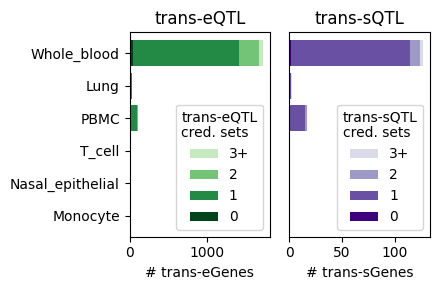

In [7]:
df = top[['tissue', 'modality', 'phenotype_id']].merge(cs_per_tissue_modality_gene, how='left')
df.n_cs = df.n_cs.fillna(0).astype(int)
df['n_cs_binned'] = bin_integers(df.n_cs.to_list(), ['0', '1', '2', '3+'])
df = df.groupby(['tissue', 'modality', 'n_cs_binned']).size().rename('n_genes').reset_index()
df = df.pivot(index=['modality', 'n_cs_binned'], values='n_genes', columns='tissue').fillna(0).astype(int).reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(4.5, 3))

for modality, ax in zip(['trans-eQTL', 'trans-sQTL'], axs.flatten()):
    to_plot = df[df.modality==modality].drop(columns='modality').set_index('n_cs_binned')
    to_plot = to_plot[tissue_order]
    to_plot = to_plot.T
    to_plot.index = pd.Categorical(to_plot.index, categories=tissue_order, ordered=True)
    cmap = 'Greens_r' if modality == 'trans-eQTL' else 'Purples_r'
    cmap = hack_cmap(cmap, len(to_plot.columns))
    to_plot.plot(kind='barh', stacked=True, ax=ax, width=0.8, cmap=cmap)

    ax.set_xlabel('# {}'.format(modality.replace('QTL', 'Genes')))
    ax.set_ylabel('')
    ax.set_title(f'{modality}')
    # reverse legend order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1]).set_title(f'{modality}\ncred. sets')
    if modality == 'trans-sQTL':
        ax.set_yticks([])
fig.tight_layout()
fig.savefig(f'figures/{PREFIX}png', bbox_inches='tight', dpi=300, facecolor='white')